In [1]:
import os

import numpy as np
import pandas as pd
import pickle as pk

import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec

import mplfinance as mpf
import matplotlib.dates as mpl_dates
import datetime

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtune
import torchtune.modules as tm

import labml_nn
from labml_nn.transformers.rope import RotaryPEMultiHeadAttention

import gc
device = torch.device('cpu')

SCRIPT_DIR = os.getcwd()
PROJECT_DIR = os.path.dirname(SCRIPT_DIR)
MAIN_DIR = os.path.dirname(PROJECT_DIR)

In [2]:
def data_prepare(data):

    data = data.copy()

    #############добавляем ema_50, ema_500############
    for col in ['volume', 'v_trades']:
        for N in [50,500]:

            a = 2 / (N + 1)
            ema = np.zeros(len(data))
            for i in range(len(ema)):
                if i == 0:
                    ema[i] = data[col][i]
                else:
                    ema[i] = a * data[col][i] + (1 - a) * ema[i-1]

            data[f'{col}_ema_{N}'] =  data[col] / ema - 1

        data.drop(columns=col, inplace=True)

    ####################################################
    
    #########переводим в относительные велечины############

    bars = data.loc[:, ['open', 'high', 'low', 'close']].values
    open = np.concatenate((bars[0][0].reshape(1), bars[:-1, -1])).reshape(-1,1)
    high = np.max((bars[::,0],bars[::,3]), axis=0).reshape(-1,1)
    low = np.min((bars[::,0],bars[::,3]), axis=0).reshape(-1,1)
    close = bars[::,0].reshape(-1,1)
    correction = np.concatenate((open, high, low, close), axis=1)
    bars = bars / correction - 1
    
    train = np.concatenate((bars, data.loc[:, data.columns[4:]].values), axis=1)
    

    ####################################################

    
    return pd.DataFrame(train, columns=data.columns)

In [3]:
def inv(x):
    return 1/(x+1) - 1

def make_voc(voc):

    vocabulary = np.array([])

    for inter in voc:
        vocabulary = np.concatenate((vocabulary, np.linspace(*inter)[:-1]))

    vocabulary = np.append(vocabulary, voc[-1][1])

    return vocabulary

voc_size = [
            [
                [inv(2), inv(1), 10+1], [inv(1), inv(0.1), 90+1],[inv(0.1), 0, 1000+1],
                [0, 0.1, 1000+1], [0.1, 1, 90+1], [1, 2, 10+1]
            ], 
            [
                [0, 0.1, 1000+1], [0.1, 1, 90+1], [1, 2, 10+1]
            ], 
            [
                [inv(2), inv(1), 10+1], [inv(1), inv(0.1), 90+1],[inv(0.1), 0, 1000+1]
            ],
            [
                [inv(100), inv(10), 90+1], [inv(10), inv(2), 80+1], [inv(2), inv(0.1), 190+1], [inv(0.1), inv(0), 1000+1],   
                [0, 0.1, 1000+1], [0.1, 2, 190+1], [2,10, 80+1], [10,100, 90+1]
            ], 
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
             ]
timesteps = [5, 10, 15, 30, 45, 60, 120, 240, 480, 720, 960, 1440]

In [4]:
folder = 'test'
clean_folder = os.path.join(PROJECT_DIR, folder, f'clean_{folder}')
done_folder = os.path.join(PROJECT_DIR, folder, f'data_done_{folder}')

datasets = np.array(os.listdir(clean_folder))


for dataset in datasets:

    data = pd.read_csv(os.path.join(clean_folder, dataset), index_col=0, parse_dates=True)


    
    for timestep in timesteps:

        ####################меняем абсолютные значения на относительные####################

        pre_train = data.resample(f"{timestep}T").agg({
                                        "open": "first",
                                        "high": "max",
                                        "low": "min",
                                        "close": "last",
                                        "volume": "sum",
                                        "trades": "sum"
                                    }).dropna()
        pre_train['v_trades'] = pre_train['volume'] / pre_train['trades']
        pre_train.drop(columns='trades', inplace=True)

        pre_train = data_prepare(pre_train)


        ######################шифруем данные при помощи словаря############################


        train = np.empty_like(pre_train)
        pre_train_v = pre_train.values

        for i in range(train.shape[-1]):

            prev_max_token = 0

            train[::,i][pre_train_v[::,i] <= voc_size[i][0][0]] = prev_max_token

            for inter in voc_size[i]:
                l = inter[0]
                r = inter[1]
                step = (r - l) / (inter[2] - 1)
                mask = (l <= pre_train_v[::,i]) & (pre_train_v[::,i] <= r)
                train[::,i][mask] = np.round((pre_train_v[::,i][mask] - l) / step) + prev_max_token
                prev_max_token += (inter[2] - 1)

            
            train[::,i][voc_size[i][-1][1] <= pre_train_v[::,i]] = prev_max_token

        train = pd.DataFrame(train, columns=pre_train.columns).astype(np.int16)


        with open(os.path.join(done_folder, f'{dataset[:-4]}_{timestep}.pkl'), 'wb') as file:
            pk.dump(train, file)
                

In [4]:
data = pd.read_csv(f'../clean/BINANCE_SPOT_XRP_USDT_2024.csv', index_col=0, parse_dates=True)
data = data.resample(f"1440T").agg({
                                "open": "first",
                                "high": "max",
                                "low": "min",
                                "close": "last",
                                "volume": "sum",
                                "trades": "sum"
                            }).dropna()
data['v_trades'] = data['volume'] / data['trades']
data.drop(columns='trades', inplace=True)

pre_train = data_prepare(data)

In [52]:
def inv(x):
    return 1/(x+1) - 1

def make_voc(voc):

    vocabulary = np.array([])

    for inter in voc:
        vocabulary = np.concatenate((vocabulary, np.linspace(*inter)[:-1]))

    vocabulary = np.append(vocabulary, voc[-1][1])

    return vocabulary

voc_size = [
            [
                [inv(2), inv(1), 10+1], [inv(1), inv(0.1), 90+1],[inv(0.1), 0, 1000+1],
                [0, 0.1, 1000+1], [0.1, 1, 90+1], [1, 2, 10+1]
            ], 
            [
                [0, 0.1, 1000+1], [0.1, 1, 90+1], [1, 2, 10+1]
            ], 
            [
                [inv(2), inv(1), 10+1], [inv(1), inv(0.1), 90+1],[inv(0.1), 0, 1000+1]
            ],
            [
                [inv(100), inv(10), 90+1], [inv(10), inv(2), 80+1], [inv(2), inv(0.1), 190+1], [inv(0.1), inv(0), 1000+1],   
                [0, 0.1, 1000+1], [0.1, 2, 190+1], [2,10, 80+1], [10,100, 90+1]
            ], 
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
            [
                [inv(100), inv(10),90+1], [inv(10), inv(1), 90+1], [inv(1), inv(0), 100+1],
                [0, 1, 100+1], [1, 10, 90+1], [10, 100, 90+1]
            ],
             ]
timesteps = [5, 10, 15, 30, 45, 60, 120, 240, 480, 720, 960, 1440]

In [53]:
train = np.empty_like(pre_train)
pre_train_v = pre_train.values

for i in range(train.shape[-1]):

    prev_max_token = 0

    train[::,i][pre_train_v[::,i] <= voc_size[i][0][0]] = prev_max_token

    for inter in voc_size[i]:
        l = inter[0]
        r = inter[1]
        step = (r - l) / (inter[2] - 1)
        mask = (l <= pre_train_v[::,i]) & (pre_train_v[::,i] <= r)
        train[::,i][mask] = np.round((pre_train_v[::,i][mask] - l) / step) + prev_max_token
        prev_max_token += (inter[2] - 1)

    
    train[::,i][voc_size[i][-1][1] <= pre_train_v[::,i]] = prev_max_token

train = pd.DataFrame(train, columns=pre_train.columns).astype(np.int16)

In [ ]:
post_train = np.empty_like(train).astype(np.float64)

for i in range(post_train.shape[-1]):

    vocabulary = np.array([])

    for inter in voc_size[i]:
        vocabulary = np.concatenate((vocabulary, np.linspace(*inter)[:-1]))

    vocabulary = np.append(vocabulary, voc_size[i][-1][1])

    #post_train[::,i] = vocabulary[train[::,i]]
    post_train[::,i] = vocabulary[train.iloc[::,i].values]

post_train = pd.DataFrame(post_train, columns=pre_train.columns)

In [96]:
def relative_to_abs(train, start_data):

    train = train.copy()

    ##############восстанавливаем фбсолютные значения переменных####################


    abs_train = pd.DataFrame(index=train.index,
                             columns=['open', 'high', 'low', 'close', 'volume', 'v_trades'])

    ##############open high low close#############################

    bars = train.loc[:, ['open', 'high', 'low', 'close']].values + 1

    bars[0,0] *= start_data['open']
    bars[0,3] *= bars[0,0]
    bars[0,1] *= np.max((bars[0,0], bars[0,3]))
    bars[0,2] *= np.min((bars[0,0], bars[0,3]))

    for i in range(1, len(bars)):
        bars[i,0] *= bars[i-1,3]
        bars[i,3] *= bars[i,0]
        bars[i,1] *= np.max((bars[i,0], bars[i,3]))
        bars[i,2] *= np.min((bars[i,0], bars[i,3]))


    abs_train[['open', 'high', 'low', 'close']] = bars


    ##############объем и средний объем транзакции####################
    a = 2 / (50 + 1)

    for col in ['volume', 'v_trades']:
        
        data = np.ones(len(abs_train)) * start_data[col]
        ema = np.ones(len(abs_train)) * start_data[col]

        ref = train[f'{col}_ema_50'] + 1

        

        for i in range(1, len(data)):
            ema[i] = ((1-a) * ema[i-1]) / (1 - a * ref[i])
            data[i] = ref[i] * ema[i]


        abs_train[col] = data

    return abs_train

In [97]:
data_abs = relative_to_abs(post_train, data.iloc[0])

In [ ]:
x = np.linspace(1,len(data), len(data))
plt.plot(x, data['close'].values - data_abs['close'].values)
plt.show()

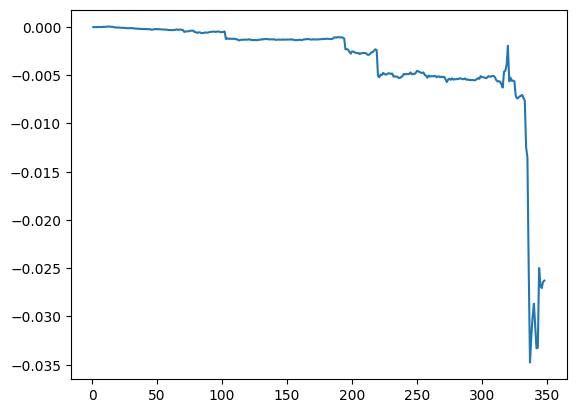

In [63]:
x = np.linspace(1,len(data), len(data))
plt.plot(x, data['close'].values - data_abs['close'].values)
plt.show()

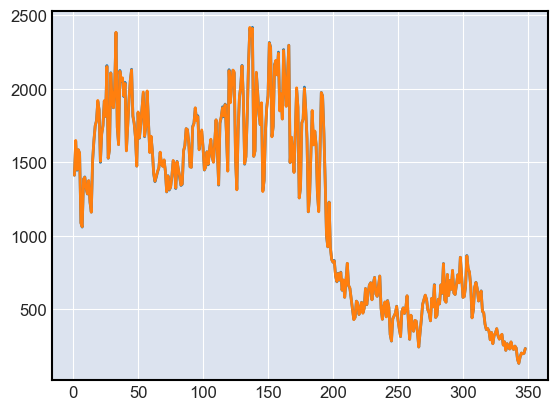

In [787]:

x = np.linspace(1, len(data), len(data))
plt.plot(x, data['v_trades'])
plt.plot(x, data_abs['v_trades'])
plt.show()

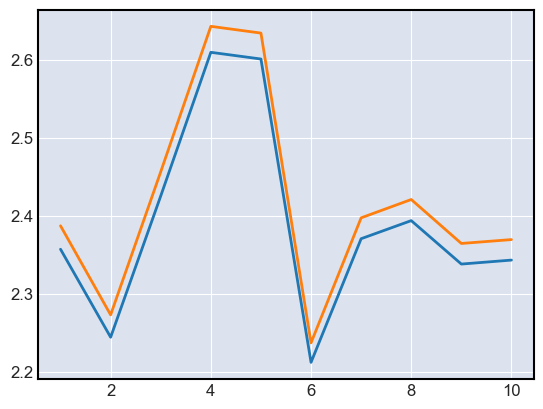

In [781]:
lim = 10
x = np.linspace(1, lim, lim)
plt.plot(x, data[-lim:]['close'])
plt.plot(x, data_abs[-lim:]['close'])
plt.show()

In [64]:
def candle_plot(data):

    ###########выводим график и дополнительные индикаторы#####################

    data.index = pd.date_range(start='2000-01-01', periods=len(data), freq='D')

    mc = mpf.make_marketcolors(up='#f2dccc',down='#716f6f',volume='inherit')
    s  = mpf.make_mpf_style(base_mpf_style='default', marketcolors=mc)

    colors = ['#f2dccc' if c >= o else '#716f6f' for c, o in zip(data['close'], data['open'])]

    ap = mpf.make_addplot(
        data['v_trades'],
        type='bar',
        panel=2,          
        color=colors,
        width = 1

    )
    fig, axes = mpf.plot(data,
                        type='candle', 
                        volume=True,
                        style=s, 
                        addplot=ap,
                        
                        figsize=(16, 10),
                        panel_ratios=(4,1,1),
                        returnfig=True)

    axes[0].set_xticks(range(0, len(data), 30))  
    axes[0].set_xticklabels(range(0, len(data), 30))
    axes[4].set_ylabel('V_trades')

    for bar in axes[2].patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(0.1)
    for bar in axes[4].patches:
        bar.set_edgecolor('black')
        bar.set_linewidth(0.1)

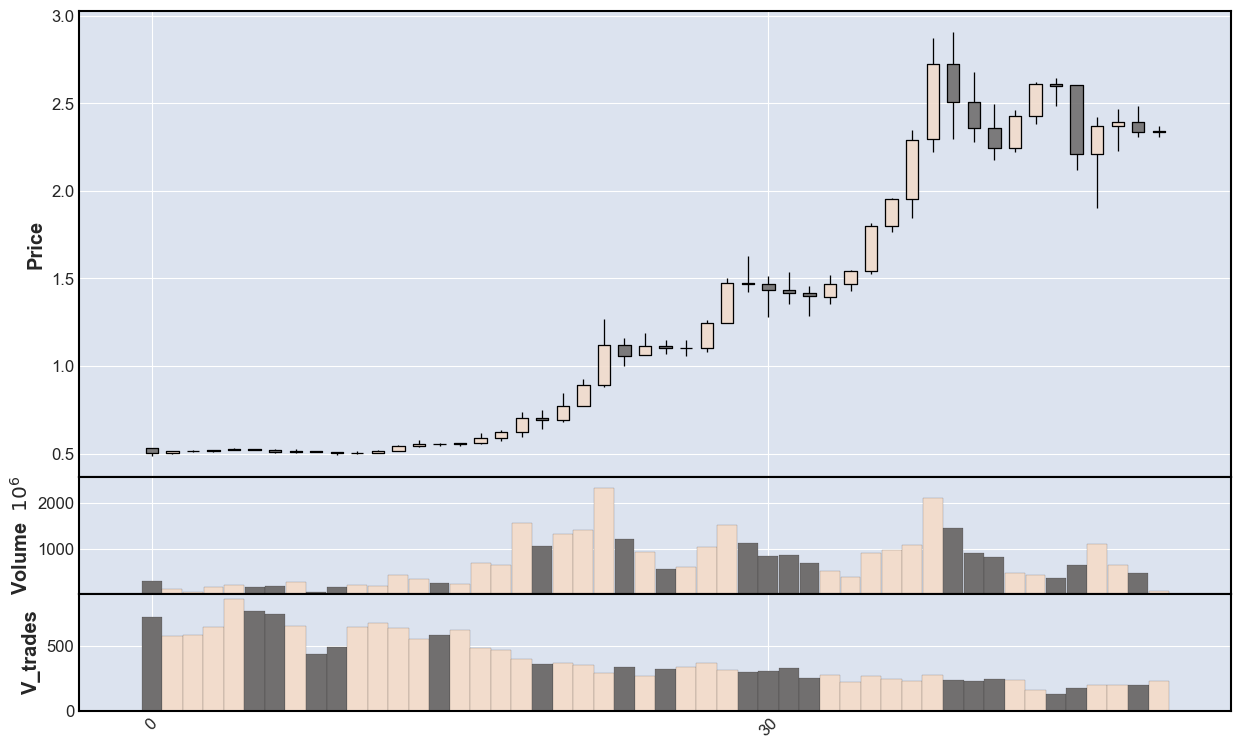

In [785]:
candle_plot(data[-50:])